In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [3]:
import sys
sys.path.append('..')

from rlmolecule.sql.run_config import RunConfig
run_config = RunConfig('../config/config_eagle_c.yaml')

In [26]:
import rdkit
from examples.stable_radical_optimization.stable_radical_molecule_state import MoleculeBuilderWithFingerprint
from rlmolecule.molecule.molecule_state import MoleculeState

prob_config = run_config.problem_config
    
builder = MoleculeBuilderWithFingerprint(
    max_atoms=prob_config.get('max_atoms', 15),
    min_atoms=prob_config.get('min_atoms', 4),
    try_embedding=prob_config.get('try_embedding', True),
    sa_score_threshold=prob_config.get('sa_score_threshold', 3.5),
    stereoisomers=prob_config.get('stereoisomers', True),
    canonicalize_tautomers=prob_config.get('canonicalize_tautomers', True),
    atom_additions=prob_config.get('atom_additions', ('C', 'N', 'O', 'S')),
    cache_dir=None,
    num_shards=prob_config.get('num_shards', 1),
    parallel=True)

state = MoleculeState(rdkit.Chem.MolFromSmiles('CC(N)S'), builder=builder)
state.get_next_actions()

[NC1CS1, CNC(C)S, CC(N)S (t)]

In [18]:
import sys
sys.path.append('/home/pstjohn/Packages/bde/')
from bde.fragment import enumerate_stereocenters

In [63]:
rdkit.__version__

'2021.03.3'

In [92]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.MolStandardize import rdMolStandardize
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

In [93]:
mol = rdkit.Chem.MolFromSmiles('CC(N)(O)S')
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(mol)]

['C[C@](N)(O)S', 'C[C@@](N)(O)S']

In [94]:
canonical_mol = tautomer_enumerator.Canonicalize(mol)
rdkit.Chem.FindMolChiralCenters(canonical_mol, includeUnassigned=True)
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(canonical_mol)]

['C[C@](N)(O)S', 'C[C@@](N)(O)S']

In [87]:
rdkit.Chem.SanitizeMol(canonical_mol, rdkit.Chem.SANITIZE_CLEANUPCHIRALITY)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [86]:
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(canonical_mol)]

['CC(N)(O)S']

[(1, '?')]

In [53]:
rdkit.Chem.AssignStereochemistry(canonical_mol, cleanIt=True, flagPossibleStereoCenters=True)

In [4]:
to_plot = pd.read_csv('possible_hits.csv')

In [12]:
from rdkit.Chem.MolStandardize import rdMolStandardize
enumerator = rdMolStandardize.TautomerEnumerator()

In [19]:
to_plot.smiles.apply(lambda x: len(list(enumerator.Enumerate(rdkit.Chem.MolFromSmiles(x)))))

RDKit WARNING: [17:18:42] Tautomer enumeration stopped at 212 tautomers: max transforms reached
RDKit WARNING: [17:18:43] Tautomer enumeration stopped at 218 tautomers: max transforms reached


0       1
1      13
2       1
3       3
4       8
       ..
147     1
148     2
149    47
150     3
151    64
Name: smiles, Length: 152, dtype: int64

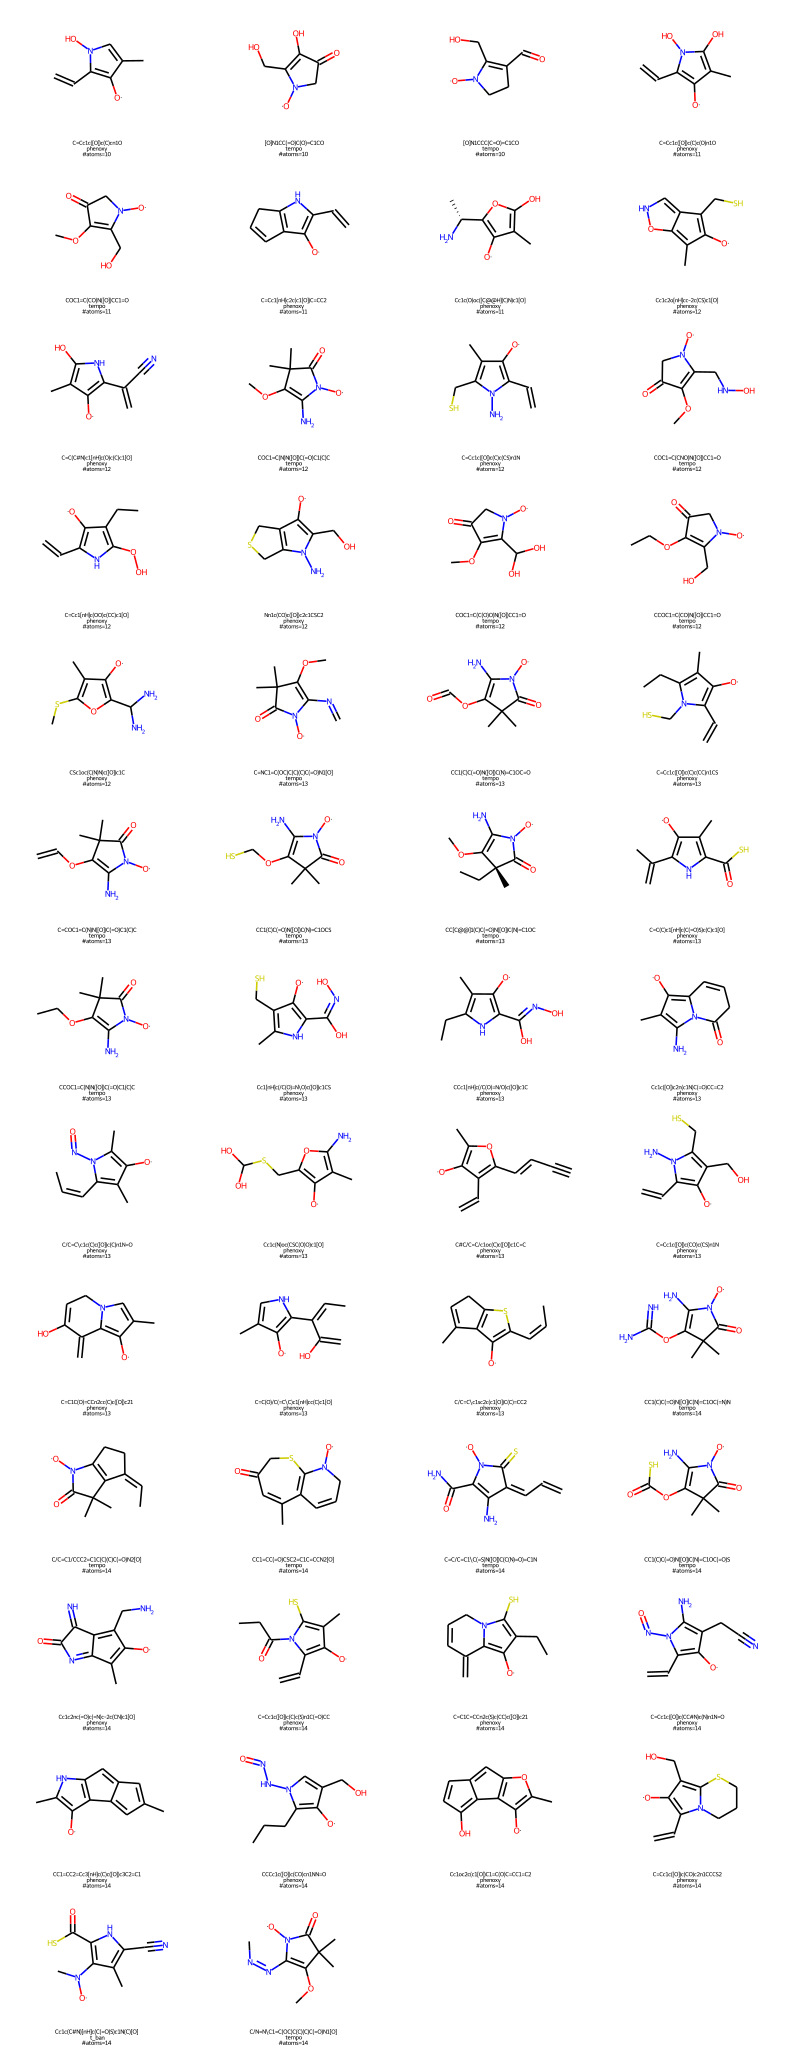

In [10]:
import rdkit
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(to_plot.smiles.apply(rdkit.Chem.MolFromSmiles), molsPerRow=4, subImgSize=(250,200), 
                legends=to_plot.apply(lambda x: f'{x.smiles}\n{x.substruct}\n#atoms={x.num_atoms}', 1).values.tolist(), useSVG=True)

In [22]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')
redox_new_calcs = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210216_fixed_rl_redox_data.csv')
tempo_results = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/tempo_results.csv')
redox_new_calcs = redox_new_calcs.append(tempo_results)

In [28]:
from tqdm import tqdm
tqdm.pandas()

def canonicalize(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    can = enumerator.Canonicalize(mol)
    return rdkit.Chem.MolToSmiles(mol)

In [29]:
redox_df['can_smiles'] = redox_df.smiles.progress_apply(canonicalize)

  3%|▎         | 2561/94743 [00:00<00:40, 2291.64it/s]RDKit WARNING: [20:47:01] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [20:47:01]   BondStereo set to STEREONONE and single bond directions set to NONE.
 43%|████▎     | 40707/94743 [00:17<00:21, 2492.11it/s]RDKit WARNING: [20:47:18] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [20:47:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
 99%|█████████▉| 93927/94743 [00:43<00:00, 1870.97it/s]RDKit WARNING: [20:47:44] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [20:47:44]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 94743/94743 [00:43<00:00, 2155.37it/s]


In [36]:
redox_df[redox_df.can_smiles != redox_df.smiles]

,smiles,ionization energy,electron affinity,oxidized_s2,reduced_s2,can_smiles
2643,C/C1=C\C=[C]\C=C/C=C/1,NaN,-1.001523,NaN,NaN,CC1=C/C=[C]/C=C\C=C\1
3444,C/C=C1\CCC\C1=C/[O],0.887317,-0.414123,NaN,NaN,C/C=C1\CCC\C1=C\[O]
3465,C/C=C1\[CH]C\C1=C/C,0.505576,-1.373822,NaN,NaN,C/C=C1\[CH]C\C1=C\C
40833,CO/C1=C\C=C\[C]=C/C=C/1,-0.094586,-1.096190,NaN,NaN,COC1=C/C=C/[C]=C\C=C\1
76101,[CH2]/C=C1\CC\C1=C/C,0.243998,-1.295890,NaN,NaN,[CH2]/C=C1\CC\C1=C\C
93954,[O]/C1=C/C=C\C=C\C=C/1,0.695154,-0.054995,NaN,NaN,[O]C1=C/C=C\C=C\C=C/1
